# Single-cell RNA-seq analysis workflow using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION. 

Licensed under the Apache License, Version 2.0 (the "License") 
you may not use this file except in compliance with the License. 
You may obtain a copy of the License at 

     http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software 
distributed under the License is distributed on an "AS IS" BASIS, 
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
See the License for the specific language governing permissions and 
limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import scanpy as sc

import os, wget

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/krasnow_hlca_10x.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/krasnow_hlca_10x.sparse.h5ad',
                  input_file)

## Set parameters

In [3]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc.settings.n_jobs=32

In [4]:
start = time.time()

## Load Data

In [5]:
%%time
adata = sc.read(input_file)

CPU times: user 201 ms, sys: 265 ms, total: 466 ms
Wall time: 464 ms


## Preprocessing

In [6]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [7]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 1.25 s, sys: 663 ms, total: 1.92 s
Wall time: 1.92 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [8]:
%%time
sc.pp.filter_genes(adata, min_cells=1)

CPU times: user 1.85 s, sys: 274 ms, total: 2.12 s
Wall time: 2.12 s


### Normalize

In [9]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 547 ms, sys: 27.5 ms, total: 575 ms
Wall time: 572 ms


In [10]:
%%time
sc.pp.log1p(adata)

CPU times: user 2.28 s, sys: 438 µs, total: 2.28 s
Wall time: 2.28 s


### Select Most Variable Genes

In [11]:
%%time
# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker+"_raw"]= adata.X[:, adata.var.index==marker].todense()

adata = adata.copy()
n_genes = sum(adata.var.highly_variable)

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 2.5 s, sys: 97.3 ms, total: 2.6 s
Wall time: 2.59 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

In [12]:
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [13]:
%%time
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_ribo'] = np.array(np.sum(adata[:, ribo_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.63 s, sys: 76 ms, total: 1.7 s
Wall time: 1.7 s


In [14]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_ribo'])

CPU times: user 8.82 s, sys: 5.95 s, total: 14.8 s
Wall time: 5min 38s


### Scale

In [15]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.87 s, sys: 159 ms, total: 2.03 s
Wall time: 2.03 s


In [16]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 351.2916805744171


## Cluster & Visualize

### Reduce

In [17]:
%%time
# PCA
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 1min 46s, sys: 33.7 s, total: 2min 20s
Wall time: 5.66 s


### TSNE + K-means

In [18]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

CPU times: user 1h 54min 22s, sys: 2min 40s, total: 1h 57min 3s
Wall time: 3min 55s


In [19]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=sc.settings.n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 4min 24s, sys: 4min 41s, total: 9min 5s
Wall time: 17.6 s


... storing 'kmeans' as categorical


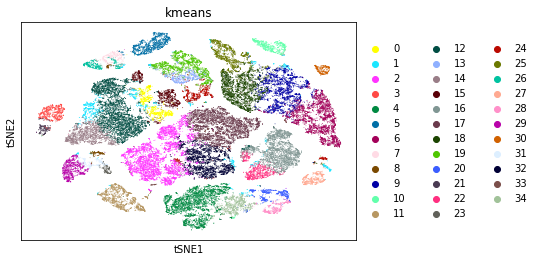

CPU times: user 4.72 s, sys: 205 ms, total: 4.93 s
Wall time: 1.55 s


In [20]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

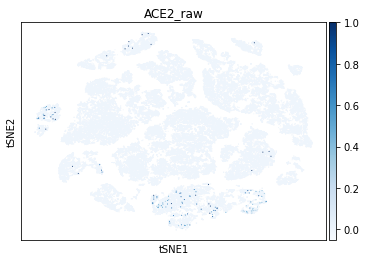

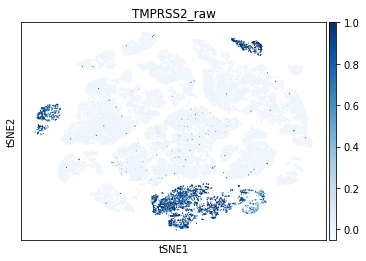

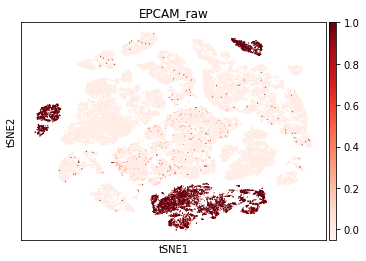

CPU times: user 1.39 s, sys: 52.7 ms, total: 1.44 s
Wall time: 1.42 s


In [21]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Graph clustering

In [22]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 57.3 s, sys: 24.6 s, total: 1min 21s
Wall time: 38.7 s


In [23]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 3min 2s, sys: 3min 4s, total: 6min 6s
Wall time: 46.3 s


In [24]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 16.8 s, sys: 93.6 ms, total: 16.9 s
Wall time: 16.9 s


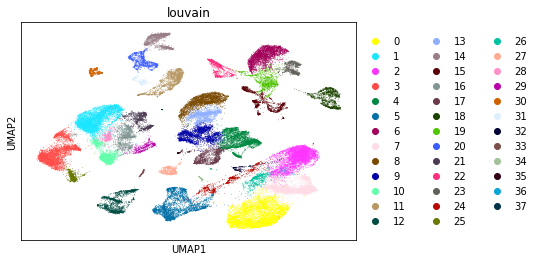

CPU times: user 1.49 s, sys: 68.3 ms, total: 1.56 s
Wall time: 1.55 s


In [25]:
%%time
# Plot
sc.pl.umap(adata, color=["louvain"])

In [26]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 16.5 s, sys: 77.9 ms, total: 16.6 s
Wall time: 16.5 s


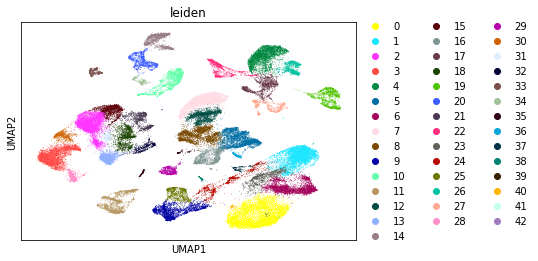

CPU times: user 1.63 s, sys: 72.5 ms, total: 1.7 s
Wall time: 1.69 s


In [27]:
%%time
# Plot
sc.pl.umap(adata, color=["leiden"])

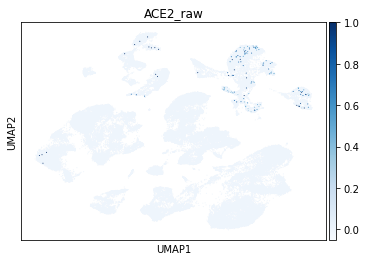

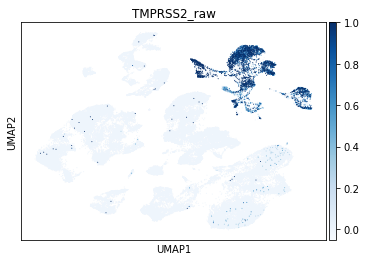

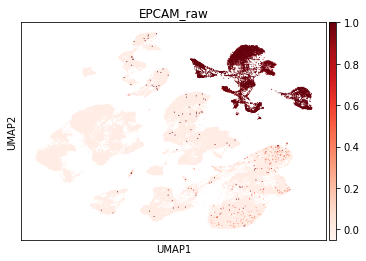

CPU times: user 1.29 s, sys: 45.3 ms, total: 1.34 s
Wall time: 1.32 s


In [28]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

## Differential expression analysis

In [29]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=ranking_n_top_genes, groups='all', reference='rest', method='logreg')

CPU times: user 37min 9s, sys: 19min 22s, total: 56min 32s
Wall time: 1min 48s


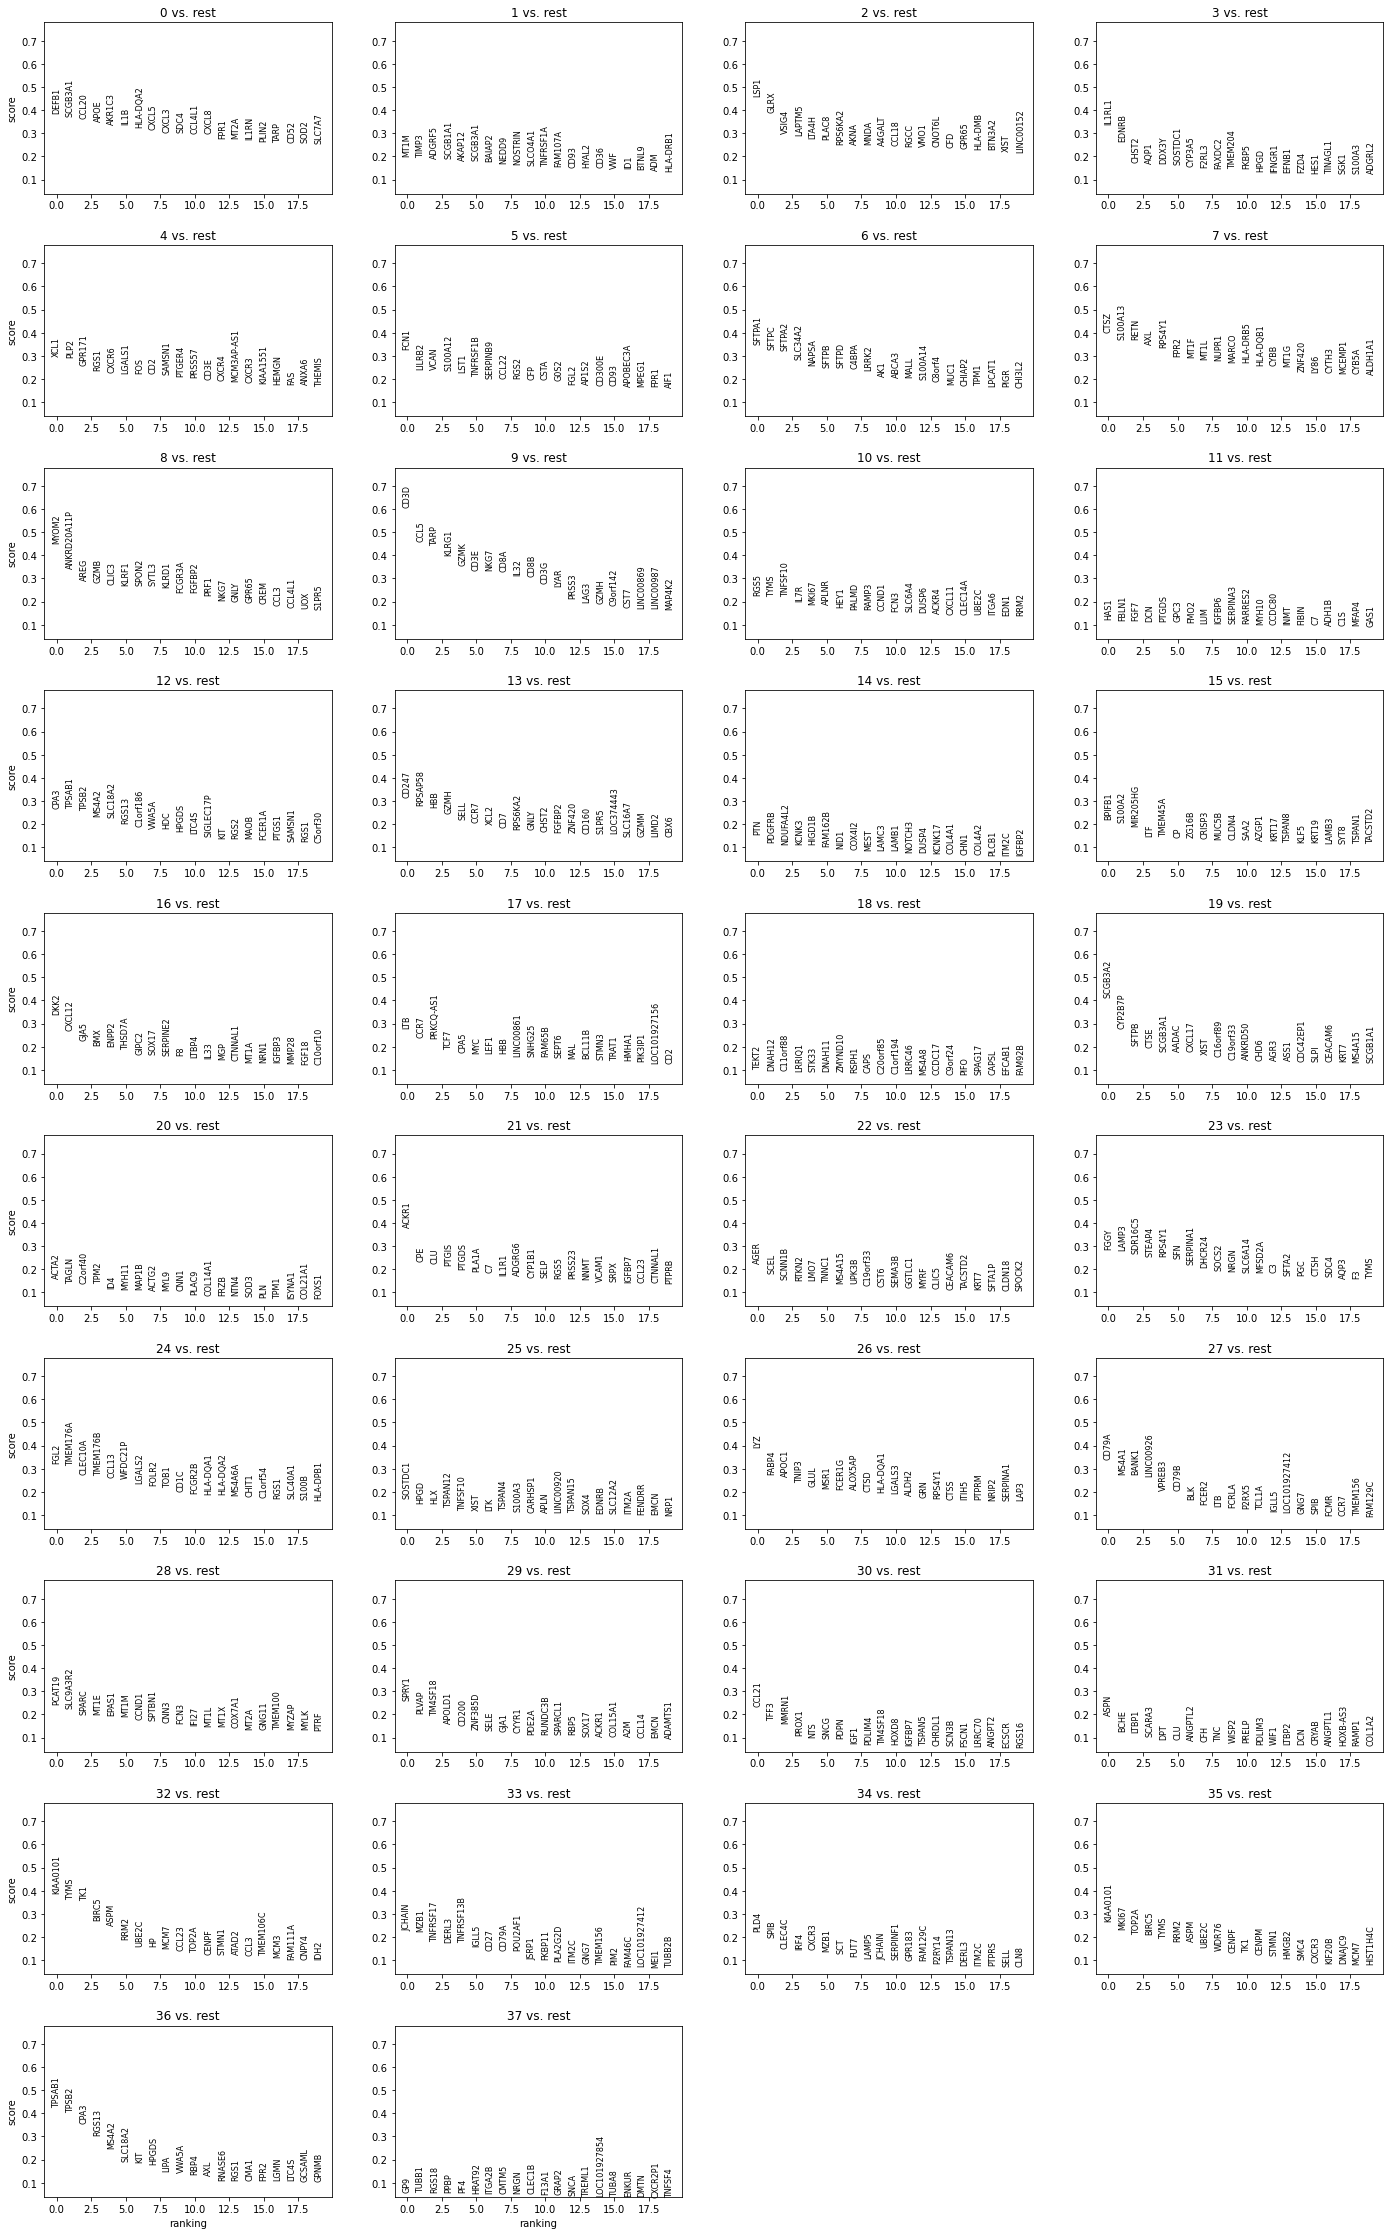

CPU times: user 9.01 s, sys: 1.55 s, total: 10.6 s
Wall time: 10.4 s


In [30]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create zoomed-in view

In [31]:
reanalysis_start = time.time()

In [32]:
%%time

adata = adata[adata.obs["EPCAM_raw"] > 0.0, :]
print(adata.X.shape)

(7958, 5000)
CPU times: user 96.7 ms, sys: 28.1 ms, total: 125 ms
Wall time: 122 ms


In [33]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 1min 8s, sys: 35.5 s, total: 1min 43s
Wall time: 26.4 s


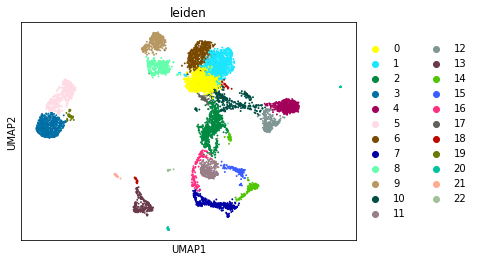

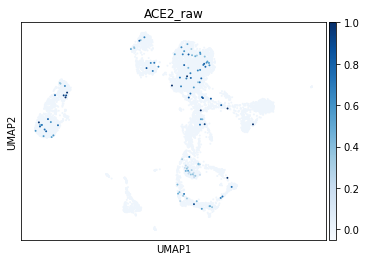

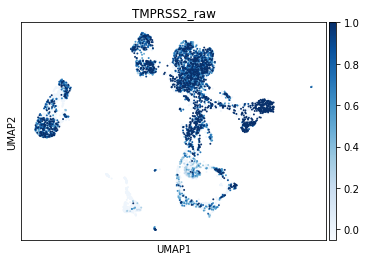

CPU times: user 1.04 s, sys: 65.4 ms, total: 1.1 s
Wall time: 1.09 s


In [34]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 27.635044813156128


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 882.9038412570953
